# Biscuit Manufacturing

## Utils imports

In [1]:
from Utils import CSPRequirements as cspr
from Utils import dataImport as di

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## First experiment : "Brutforce"-like backtrack

In this first test, we're trying all possible combinations using backtracking. This technique takes a gigantic amount of steps to iterate through all possible roll that respect the intial constraints:

- No overlap
- Total biscuit length <= roll length
- Biscuit placements respect the defects thresholds

Technically it can work, to prove so, we'll imagine our roll is only 50 units long, to prove that we get an optimized result. Limiting to 50 lowers the computation time to something feasble. 

After proving this basic technique works, we'll try to implements heursitics and other conditions to limit the exploration and amount of steps to find a solution.

In [2]:
roll_length = 50

# Biscuit thresholds
biscuit_thresholds = {
    0: {'size': 4, 'a': 4, 'b': 2, 'c': 3, 'value': 3},
    1: {'size': 8, 'a': 5, 'b': 4, 'c': 4, 'value': 12},
    2: {'size': 2, 'a': 1, 'b': 2, 'c': 1, 'value': 1},
    3: {'size': 5, 'a': 2, 'b': 3, 'c': 2, 'value': 8}
}

# Initialize roll and defect data
roll = di.build_roll(di.importDefects("defects.csv"), roll_length)
problem = cspr.BiscuitProblem(name="BiscuitOptimization", rollLength=roll_length, defect_data=roll, biscuit_thresholds=biscuit_thresholds)

print("Length of the roll: ", len(problem.roll))
problem.backtrack()

Length of the roll:  50


We can extract the best value for our roll (that respects all the constraints) and the corresponding roll

In [3]:
bestValue1 = problem.bestValue
bestRoll1 = problem.bestRoll
stepsTaken1 = problem.step

print(problem.bestValue)
print(problem.bestRoll)

76
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Plot

To have a better idea of what our backtracking algorithm did, let's see how the best value evolved:

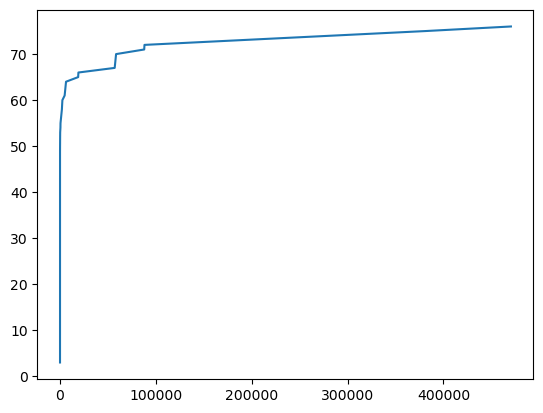

In [4]:
bestValues = []
bestValuesRank = []

for x in problem.bestValues:
    bestValues.append(x[0])
    bestValuesRank.append(x[1])

plt.plot(bestValuesRank, bestValues)

## Improving the solution : Parallelization

This is great ! Our algorithm works. But not optimized enough to give us solutions for greater roll length values in our lifespan. Let's try and optimize this.

Parallelizing tasks can help reduce global complexity. For instance: there are 2,656,615,626 combinations (with repetition) of 500 elements among 5 items (here, our biscuits (0,1,2,3) and "None". Note: this doesn't take into acount our constraints).

If we split the 500 items list into two 250 items list, we have 2 lists of 169,362,501 possible combinations. Thus a total of 338,725,002 states to explore.

if we further split our "main list", in for instance, 10 sub-lists (bins) of 50 elements. There are only 316,251 combinations of 5 elements among 50 items. Thus, a total of 3,162,510 states to explore. 

This technique would give us 10 optimized lists. We can suppose that the combination of these optimized sub-lists can yield a fair approximation of the best result in a more than reasonable amount of time.

### Python implementation


In [5]:
def parallel_solver(roll_length, n_split):
    roll = di.build_roll(di.importDefects("defects.csv"), roll_length)
    sub_rolls = di.split_roll(roll, n_split)

    bestValues = []
    bestRolls = []
    stepsTakenList = []

    for i in range(n_split):
        print("Processing sub_roll : ", i)
        problem = cspr.BiscuitProblem(name="BiscuitOptimization", rollLength=len(sub_rolls[i]), defect_data=sub_rolls[i], biscuit_thresholds=biscuit_thresholds)
        problem.backtrack()
        bestValues.append(problem.bestValue)
        bestRolls.append(problem.bestRoll)
        stepsTakenList.append(problem.step)

    
    bestRoll = di.build_back_roll(bestRolls)

    bestValue = 0
    for value in bestValues:
        bestValue += value

    stepsTaken = 0
    for value in stepsTakenList:
        stepsTaken += value

    print("Finished parallel solve")
    return bestValue, bestRoll, stepsTaken

### Comparing results to the previous solve

In [6]:
bestValue2, bestRoll2, stepsTaken2 = parallel_solver(50, 2)

Processing sub_roll :  0
Processing sub_roll :  1
Finished parallel solve


In [7]:
print("No parallel Stats :\n- Roll value: ", bestValue1, "\n- Steps taken: ", stepsTaken1, "\n\nParallel solve stats :\n- Roll value: ", bestValue2, "\n- Steps taken: ", stepsTaken2)

No parallel Stats :
- Roll value:  76 
- Steps taken:  480842 

Parallel solve stats :
- Roll value:  73 
- Steps taken:  992


For a value **4% off** the best value, we saved **1901% of the computation time.**

### Getting a first approximation for the 500 units long roll

In [8]:
bestValue3, bestRoll3, stepsTaken3 = parallel_solver(500, 13)

Processing sub_roll :  0
Processing sub_roll :  1
Processing sub_roll :  2
Processing sub_roll :  3
Processing sub_roll :  4
Processing sub_roll :  5
Processing sub_roll :  6
Processing sub_roll :  7
Processing sub_roll :  8
Processing sub_roll :  9
Processing sub_roll :  10
Processing sub_roll :  11
Processing sub_roll :  12
Finished parallel solve


Splitting in 13 rolls gives a good in-between computation time / splits. (We want as few splits as possible to get as close as possible to the actual solution). 

In [9]:
print("Parallel 500 solve stats :\n- Roll value: ", bestValue3, "\n- Steps taken: ", stepsTaken3)

Parallel 500 solve stats :
- Roll value:  758 
- Steps taken:  1171889


We now have a base result approximation to compare other algorithms we'll implement !

## Genetic Algorithm and Neural Network !

In [10]:
# Function to convert defects to one-hot encoded vector
def encode_defects(defects, defect_types):
    one_hot = [0] * len(defect_types)  # Initialize a zero vector
    for defect in defects:
        if defect in defect_types:
            one_hot[defect_types.index(defect)] = 1  # Set the corresponding index to 1
    return one_hot

In [12]:
# Biscuit thresholds
biscuit_thresholds = {
    0: {'size': 4, 'a': 4, 'b': 2, 'c': 3, 'value': 3},
    1: {'size': 8, 'a': 5, 'b': 4, 'c': 4, 'value': 12},
    2: {'size': 2, 'a': 1, 'b': 2, 'c': 1, 'value': 1},
    3: {'size': 5, 'a': 2, 'b': 3, 'c': 2, 'value': 8}
}

In [13]:
from Utils import GeneticAlgorithmRequirements as ga

Generation 0, Best Fitness: -676.0000
Generation 1, Best Fitness: -676.0000
Generation 2, Best Fitness: -676.0000
Generation 3, Best Fitness: -676.0000
Generation 4, Best Fitness: -676.0000
Generation 5, Best Fitness: -676.0000
Generation 6, Best Fitness: -676.0000
Generation 7, Best Fitness: -676.0000
Generation 8, Best Fitness: -256.0000
Generation 9, Best Fitness: -256.0000
Generation 10, Best Fitness: -256.0000
Generation 11, Best Fitness: -256.0000
Generation 12, Best Fitness: -256.0000
Generation 13, Best Fitness: -256.0000
Generation 14, Best Fitness: -256.0000
Generation 15, Best Fitness: -256.0000
Generation 16, Best Fitness: -256.0000
Generation 17, Best Fitness: -256.0000
Generation 18, Best Fitness: -256.0000
Generation 19, Best Fitness: -256.0000
Generation 20, Best Fitness: -256.0000
Generation 21, Best Fitness: -256.0000
Generation 22, Best Fitness: -256.0000
Generation 23, Best Fitness: -256.0000
Generation 24, Best Fitness: -256.0000
Generation 25, Best Fitness: -256.0

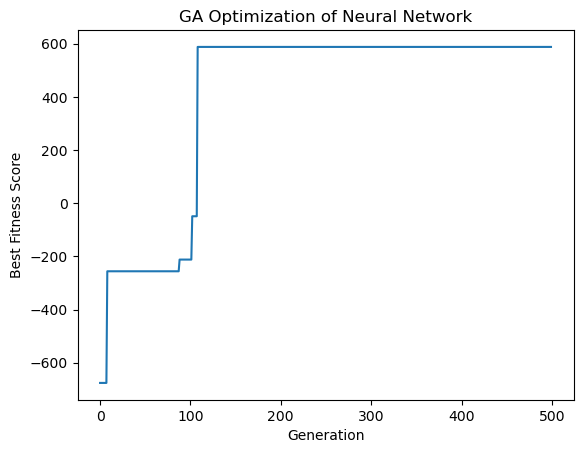

In [182]:
best_fitnesses = []
n_generations = 500
n_elites = 10
population_size = 100
mutation_rate = 0.2
roll_length = 500 # Length of the roll
vision_range = 12


defect_data = di.build_roll(di.importDefects("defects.csv"), roll_length)  # Defects input data (e.g., size 50)
defect_types = ['a', 'b', 'c', 'o']  # Define your defect types (update as needed)
encoded_defects = [encode_defects(defects, defect_types) for defects in defect_data]

myGa =ga.GeneticAlgorithm(population_size, 4, 32, 5, encoded_defects, biscuit_thresholds, roll_length, vision_range)

best_fitnesses = myGa.solve(n_elites, n_generations, mutation_rate)


# Plot the process
plt.plot(best_fitnesses)
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('GA Optimization of Neural Network')
plt.show()

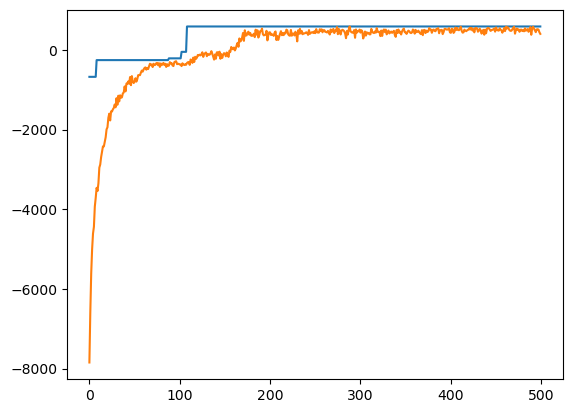

In [184]:
plt.plot(best_fitnesses)
plt.plot(myGa.avg_scores)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

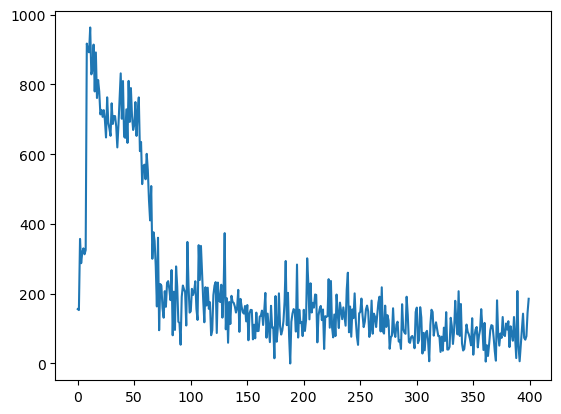

In [185]:
deltaFitness = []
for i in range(len(best_fitnesses)):
    deltaFitness.append(best_fitnesses[i]-myGa.avg_scores[i])

plt.plot(deltaFitness[100:])
plt.show

In [186]:
bestScore4, bestRoll4 = myGa.solve_with(myGa.best_individual)
print(bestRoll3)
print(bestRoll4)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [187]:
def count_true_roll_value(roll, biscuit_thresholds):
    rank = 0
    isViable = True
    value = 0
    while rank < len(roll):
        if roll[rank] is not None:
            biscuitType = roll[rank]
            for i in range(rank, rank + biscuit_thresholds[biscuitType]['size']):
                if roll[i] != biscuitType:
                    isViable = False
            rank += biscuit_thresholds[biscuitType]['size']
            value += biscuit_thresholds[biscuitType]['value']
        else:
            value -= 1
            rank += 1

    return value, isViable

In [ ]:
value3, isViable3 = count_true_roll_value(bestRoll3, biscuit_thresholds)
value4, isViable4 = count_true_roll_value(bestRoll4, biscuit_thresholds)
stepsTaken4 = myGa.steps

print("Value 3 : ", value3, " Is Viable 3 : ", isViable3)
print("Value 4 : ", value4, " Is Viable 4 : ", isViable4)


Value 3 :  758  Is Viable 3 :  True
Value 4 :  696  Is Viable 4 :  True


### Neural Network parallelized

In [224]:
best_fitnesses = []
n_generations = 200
n_elites = 10
population_size = 100
mutation_rate = 0.2
sub_roll_length = 250 # Length of the roll
vision_range = 12


defect_data = di.build_roll(di.importDefects("defects.csv"), roll_length)  # Defects input data (e.g., size 50)
defect_types = ['a', 'b', 'c', 'o']  # Define your defect types (update as needed)
encoded_defects = [encode_defects(defects, defect_types) for defects in defect_data]

encoded_defects1 = encoded_defects[0:250]
encoded_defects2 = encoded_defects[250:500]

myGa1 =ga.GeneticAlgorithm(population_size, 4, 32, 5, encoded_defects1, biscuit_thresholds, sub_roll_length, vision_range)
myGa2 =ga.GeneticAlgorithm(population_size, 4, 32, 5, encoded_defects2, biscuit_thresholds, sub_roll_length, vision_range)

best_fitnesses1 = myGa1.solve(n_elites, n_generations, mutation_rate)
best_fitnesses2 = myGa2.solve(n_elites, n_generations, mutation_rate)


bestScoreSub1, bestRollSub1 = myGa1.solve_with(myGa1.best_individual)
bestScoreSub2, bestRollSub2 = myGa2.solve_with(myGa2.best_individual)

bestRoll5 = []
for element in bestRollSub1:
    bestRoll5.append(element)

for element in bestRollSub2:
    bestRoll5.append(element)

Generation 0, Best Fitness: 256.0000
Generation 1, Best Fitness: 256.0000
Generation 2, Best Fitness: 256.0000
Generation 3, Best Fitness: 256.0000
Generation 4, Best Fitness: 256.0000
Generation 5, Best Fitness: 256.0000
Generation 6, Best Fitness: 256.0000
Generation 7, Best Fitness: 268.0000
Generation 8, Best Fitness: 268.0000
Generation 9, Best Fitness: 268.0000
Generation 10, Best Fitness: 268.0000
Generation 11, Best Fitness: 268.0000
Generation 12, Best Fitness: 268.0000
Generation 13, Best Fitness: 268.0000
Generation 14, Best Fitness: 268.0000
Generation 15, Best Fitness: 268.0000
Generation 16, Best Fitness: 268.0000
Generation 17, Best Fitness: 276.0000
Generation 18, Best Fitness: 276.0000
Generation 19, Best Fitness: 276.0000
Generation 20, Best Fitness: 276.0000
Generation 21, Best Fitness: 276.0000
Generation 22, Best Fitness: 276.0000
Generation 23, Best Fitness: 276.0000
Generation 24, Best Fitness: 276.0000
Generation 25, Best Fitness: 276.0000
Generation 26, Best Fi

In [ ]:
value5, isViable5 = count_true_roll_value(bestRoll5, biscuit_thresholds)

print("Value 3 : ", value3, " Is Viable 3 : ", isViable3)
print("Value 4 : ", value4, " Is Viable 4 : ", isViable4)
print("Value 5 : ", value5, " Is Viable 5 : ", isViable5)

Value 5 :  654  Is Viable 5 :  True
500
